# Example analysis using the Grid Class

### It takes in the Q tensor and the velocity fields from stored data to compute vorticity, active force and other features relevant in active nematics.
### The terms calculated can be found in the equations in the following reference - https://doi.org/10.1103/PhysRevE.97.012702

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import re
import sys

### Define the parameters of the data

# Grid Size
NX=128
NY=128

# Box Dimensions
a = 0.0
b = 200.0
x = np.linspace(a,b,NX)
y = np.linspace(a,b,NY)
[X,Y] = np.meshgrid(x,y,indexing='ij')
dx = x[1] - x[0]
dy = y[1] - y[0]
h = [dx,dy]

### Loading the data

# This function takes in the path for a data file and loads it in the appropriate form as a 2D field.
def loadfile(filepath,NX,NY):
    f = open(filepath,'rb')
    field = np.reshape(np.fromfile(f,dtype='float64',count=NX*NY), [NX,NY],order='C')
    f.close()
    return(field)

# File paths of the relevant fields.

# Path of the directory which contains Q tensor and velocity data
data_dir = f"{os.getcwd()}/data" # Change according to requirements
frame = 5000
f_Qxx = f"{data_dir}/Qxx_{frame}.dat"
f_Qxy = f"{data_dir}/Qxy_{frame}.dat"
f_ux = f"{data_dir}/ux_{frame}.dat"
f_uy = f"{data_dir}/uy_{frame}.dat"

# Load into arrays
Qxx = loadfile(f_Qxx,NX,NY)
Qxy = loadfile(f_Qxy,NX,NY)
ux = loadfile(f_ux,NX,NY)
uy = loadfile(f_uy,NX,NY)

### Preprocessing the data

In [4]:
# Transorm the Q tensor such that it is of the form: Qxx = nx^2 - 1/2 and Qxy = nx*ny
# S is the "order" of the nematic.
# If S is high, then the director is smooth.
# If S is low, there might be defects nearby.
S = 2*np.sqrt( Qxx**2 + Qxy**2)
Qxx = Qxx/S
Qxy = Qxy/S

## The Q tensor from here is of the correct form.

nx= np.sqrt(Qxx + 0.5)
ny= np.abs(Qxy/nx) # This ensures ny>0, such that theta lies between 0 to pi
nx = nx*np.sign(Qxy) # This gives back nx its correct sign.

theta = np.arctan2(ny,nx)

u = np.array([ux, uy]) # The shape of this array is (2,NX,NY)
# ux = u[0], uy = u[1]
print(f"Shape of u = {u.shape}")
# This is the Q tensor.
# Ot has components Q11 = Qxx, Q12 = Qxy,
# Q21 = Qxy, Q22 = Qyy (= -Qxx by definition)
Q = np.array([[Qxx, Qxy],[Qxy, -Qxx]]) # The shape of this array is (2,2,NX,NY)
# Qxx = Q[0][0], Qxy = Q[0][1] and so on.
print(f"Shape of Q = {Q.shape}")

Shape of u = (2, 128, 128)
Shape of Q = (2, 2, 128, 128)


## Compute relevant features using the Grid class

### Active force = $\nabla \cdot \mathbf{Q}$ (Vector quantity, since $\mathbf{Q}$ is a tensor.)

Shape of divQ = (2, 128, 128)


<IPython.core.display.Javascript object>


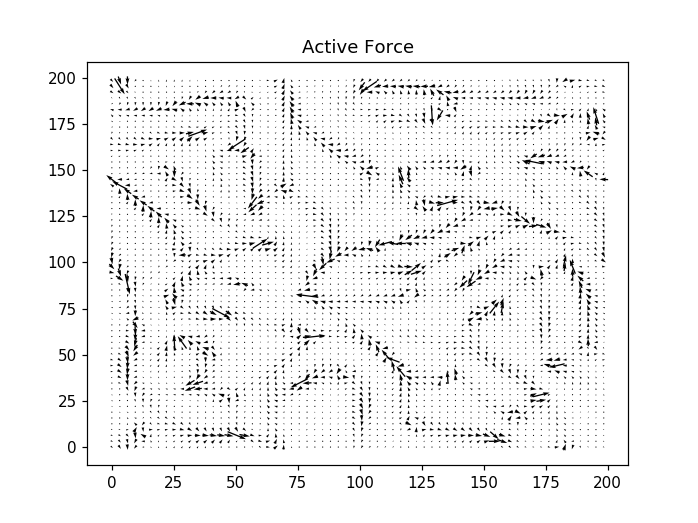

In [5]:
from grid import *

grid = Grid(h=h,boundary="periodic")

# Now, probably the most important term - the activity.
# The term multiplying alpha is the divergence of Q
divQ = grid.div(Q) # This will have a shape of (2,NX,NY), same as u and lapu
# divQ[0] = x component, and divQ[1] = y component of "Active force", upto a factor of alpha
print(f"Shape of divQ = {divQ.shape}")

# img1 = plt.pcolor(XW,YW,S,vmin=0.0,vmax=1.0)
# plt.colorbar(img1)
skip=2
%matplotlib notebook
plt.figure()
plt.quiver(X[::skip,::skip],Y[::skip,::skip],divQ[0][::skip,::skip],divQ[1][::skip,::skip],
               scale=15.0,pivot="mid")
plt.title('Active Force')
# plt.quiver(XW[::skip,::skip],YW[::skip,::skip],nx[::skip,::skip],ny[::skip,::skip],
#                headwidth=0.0, scale=30.0,pivot="mid")
# plt.quiver(XW[::skip,::skip],YW[::skip,::skip],ux[::skip,::skip],uy[::skip,::skip],
#                scale=15.0,pivot="mid")
# plt.title('Vector plot of velocity superimposed on the color plot of order')
# plt.title('Vector plot of director superimposed on the color plot of order')
# plt.title('Vector plot of active force superimposed on the color plot of order')
plt.show()

### Vorticity = $\nabla \times \vec{v}$ (Scalar when $\vec{v}$ is 2D) 

Shape of vort = (128, 128)


<IPython.core.display.Javascript object>


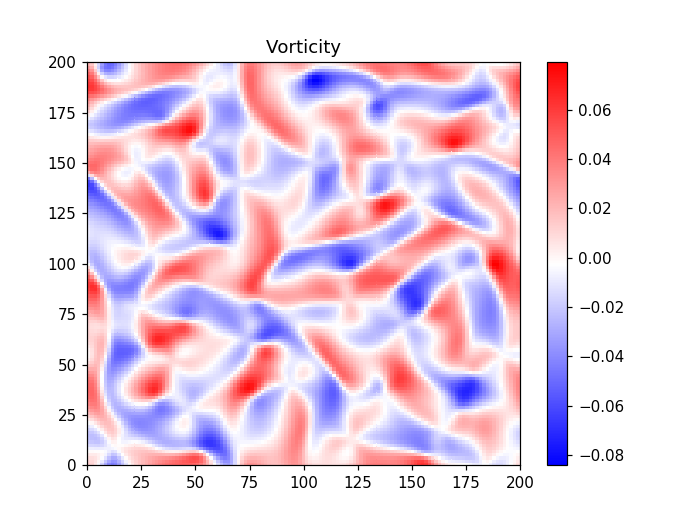

Text(0.5, 1.0, 'Vorticity')

In [6]:
vort = grid.curl(u)
print(f"Shape of vort = {vort.shape}")

plt.figure()
img1 = plt.pcolor(X,Y,vort,cmap='bwr')
plt.colorbar(img1)
plt.title('Vorticity')

### Sources or sinks in velocity ($\nabla \cdot \vec{v}$) - Expected to be slightly non-zero due to friction

Shape of div_v = (128, 128)


<IPython.core.display.Javascript object>


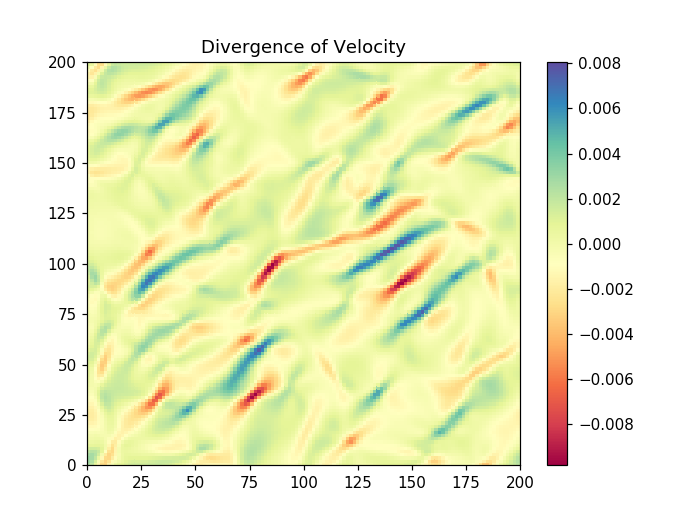

Text(0.5, 1.0, 'Divergence of Velocity')

In [7]:
div_v = grid.div(u)
print(f"Shape of div_v = {div_v.shape}")

plt.figure()
img1 = plt.pcolor(X,Y,div_v,cmap='Spectral')
plt.colorbar(img1)
plt.title('Divergence of Velocity')

### Other relevant quantities

In [11]:
del_i_u_j = grid.grad(u) # This is \partial_i u_j. Its shape is (2,2,NX,NY)
# dx[ux] = del_i_u_j[0][0], dy[ux] = del_i_u_j[1][0]
print(f"Shape of del_i_u_j = {del_i_u_j.shape}")
del_j_u_i = np.swapaxes(del_i_u_j,0,1)

Omega = (1.0/2)*(del_i_u_j - del_j_u_i)
E = (1.0/2)*(del_i_u_j + del_j_u_i)
E_tau = E # This is because in our case, E_kk is zero.
# This is because of the incompressibility constraint (div.u=0 => sum on k del_k_u_k = 0)

# Now we calculate the vorticity coupling (Q.Omega and Omega.Q)

# The following notation means - 
# Q_Omega_ij = sum on k (Q_ik times Omega_kj)
Q_Omega = np.einsum('ik...,kj...->ij...',Q,Omega) # The shape of this array is (2,2,NX,NY)
print(f"Shape of Q_Omega = {Q_Omega.shape}")
Omega_Q = np.einsum('ik...,kj...->ij...',Omega,Q)
print(f"Shape of Omega_Q = {Omega_Q.shape}")


## Now we move on to gamma_{-1} H_ij from eqn 4

# The term multiplying beta2 is Tr[Q^2], i.e. the trace of Q^2.
# Q^2 is defined as (Q^2)_lm = sum on k (Q_lk times Q_km)
# Hence Tr[Q^2] = sum on l (Q^2)_ll = sum on k and l (Q_lk times Q_kl)
# Note that this would be a scalar field
TrQ2 = np.einsum('lk...,kl...->...',Q,Q) # The shape of this array is (NX,NY)
print(f"Shape of TrQ2 = {TrQ2.shape}")

# The term multiplying DE is the laplacian of Q
lapQ = grid.lap(Q)
print(f"Shape of lapQ = {lapQ.shape}")

# Again, we don't care about the term multiplying DA as it is a boundary term.

## Now moving to equation 5
# First term is the laplacian of u
lapu = grid.lap(u,h=h) # The shape of this array is (2,NX,NY)
# lapu[0] = lap(ux) and lapu[1] = lap(uy)
print(f"Shape of lapu = {lapu.shape}")

Shape of del_i_u_j = (2, 2, 128, 128)
Shape of Q_Omega = (2, 2, 128, 128)
Shape of Omega_Q = (2, 2, 128, 128)
Shape of TrQ2 = (128, 128)
Shape of lapQ = (2, 2, 128, 128)
Shape of lapu = (2, 128, 128)
